#### Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from itertools import combinations
from uszipcode import SearchEngine
%matplotlib inline
plt.style.use('seaborn')

In [5]:
df = pd.read_csv('Data/df_cleaned.csv')
df.head()

,date_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,yr_built,...,lat,long,sqft_living15,sqft_lot15,basement,renovated,condition,grade,city,location
0,735519,221900.0,3,1,1180,5650,1,0,1180,1955,...,47.5112,-122.257,1340,5650,0,0,2,4,Seattle,SW
1,735576,538000.0,3,2,2570,7242,2,0,2170,1951,...,47.7210,-122.319,1690,7639,1,1,2,4,Seattle,NW
2,735654,180000.0,2,1,770,10000,1,0,770,1933,...,47.7379,-122.233,2720,8062,0,0,2,3,Kenmore,NE
3,735576,604000.0,4,3,1960,5000,1,0,1050,1965,...,47.5208,-122.393,1360,5000,1,0,4,4,Seattle,NW
4,735647,510000.0,3,2,1680,8080,1,0,1680,1987,...,47.6168,-122.045,1800,7503,0,0,2,5,Sammamish,NE


#### Final Call on Variables

* Dependent Variable (target):
  - Price
 
 
* Independent Variables:
  - **Continuous**: ['sqft_living','yr_built','sqft_above','waterfront','condition','floors','bedrooms','basement','renovated','bathrooms', 'grade']




  - **Drop**: ['sqft_lot', 'sqft_lot15','date_sold','zipcode','lat','long']
  
     - **sqft_lot** and **sqft_lot15**: there is no linear relationship with target variable
     - **zipcode**: by using zipcode we added the **city** column
     - **lat** and **long**: by using them a column named **location** added
     - **date_sold**: we have all kind of prices in each date of a year 
     
     

   - **Create dummies**: ['location', 'city']
  
  

   - **Binary Variables**: ['renovated','basement','waterfront']

  

In [6]:
categoricals = ['city','location']

continuous = ['sqft_living''yr_built','sqft_above','waterfront','condition','floors','bedrooms'
              ,'sqft_living15','grade','basement','renovated','bathrooms','grade']

deleted = ['sqft_lot15','sqft_lot','date_sold','zipcode','lat','long']

In [7]:
#creating our final DataFrame after doing some research on categorical and continuous variables 
dummies = df[categoricals].astype('category')
dummies = pd.get_dummies(dummies,prefix=dummies.columns, drop_first=True)
df_preprocessed = df.drop(categoricals, axis=1)
df_preprocessed = pd.concat([df_preprocessed, dummies], axis=1)
df_preprocessed = df_preprocessed.drop(deleted, axis=1)
df_fin_cat = df_preprocessed.copy()
df_fin_cat.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,sqft_above,yr_built,sqft_living15,basement,...,city_Redmond,city_Renton,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,location_NW,location_SE,location_SW
0,221900.0,3,1,1180,1,0,1180,1955,1340,0,...,0,0,0,1,0,0,0,0,0,1
1,538000.0,3,2,2570,2,0,2170,1951,1690,1,...,0,0,0,1,0,0,0,1,0,0
2,180000.0,2,1,770,1,0,770,1933,2720,0,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3,1960,1,0,1050,1965,1360,1,...,0,0,0,1,0,0,0,1,0,0
4,510000.0,3,2,1680,1,0,1680,1987,1800,0,...,0,0,1,0,0,0,0,0,0,0


In [8]:
df_fin_cat.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'sqft_above', 'yr_built', 'sqft_living15', 'basement', 'renovated',
       'condition', 'grade', 'city_Bellevue', 'city_Black Diamond',
       'city_Bothell', 'city_Carnation', 'city_Duvall', 'city_Enumclaw',
       'city_Fall City', 'city_Federal Way', 'city_Issaquah', 'city_Kenmore',
       'city_Kent', 'city_Kirkland', 'city_Maple Valley', 'city_Medina',
       'city_Mercer Island', 'city_North Bend', 'city_Redmond', 'city_Renton',
       'city_Sammamish', 'city_Seattle', 'city_Snoqualmie', 'city_Vashon',
       'city_Woodinville', 'location_NW', 'location_SE', 'location_SW'],
      dtype='object')

#### Address Multicolinearity Before Train-Test_Split

In [9]:
#create a dataframe to address multicolinearity
df_fin_mcl = df_fin_cat.corr().abs().stack().reset_index().sort_values(0,ascending=False)
df_fin_mcl['pairs'] = list(zip(df_fin_mcl.level_0,df_fin_mcl.level_1))
df_fin_mcl.set_index(['pairs'],inplace=True)
df_fin_mcl.drop(columns=['level_0','level_1'],inplace=True)
df_fin_mcl.columns = ['Correlation']
df_fin_mcl.drop_duplicates(inplace=True)
df_fin_mcl[(df_fin_mcl.Correlation>.70)&(df_fin_mcl.Correlation<1)]

,Correlation
pairs,
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living15, sqft_above)",0.731767
"(sqft_living, bathrooms)",0.720891
"(grade, sqft_living15)",0.713867
"(price, sqft_living)",0.701917


* There is a high multicolinearity between squarefoot living and squarefoot above, so we decided to drop squarefeet above to reduce multicolinearity in our dataset.

In [10]:
df_fin_cat.drop('sqft_above', axis=1, inplace=True)

In [11]:
df_fin_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 38 columns):
price                 21597 non-null float64
bedrooms              21597 non-null int64
bathrooms             21597 non-null int64
sqft_living           21597 non-null int64
floors                21597 non-null int64
waterfront            21597 non-null int64
yr_built              21597 non-null int64
sqft_living15         21597 non-null int64
basement              21597 non-null int64
renovated             21597 non-null int64
condition             21597 non-null int64
grade                 21597 non-null int64
city_Bellevue         21597 non-null uint8
city_Black Diamond    21597 non-null uint8
city_Bothell          21597 non-null uint8
city_Carnation        21597 non-null uint8
city_Duvall           21597 non-null uint8
city_Enumclaw         21597 non-null uint8
city_Fall City        21597 non-null uint8
city_Federal Way      21597 non-null uint8
city_Issaquah         21597 n

#### Train-Test-Split 

* We use TTS to create our basemodel and continue to train our model on train set

In [12]:
target = 'price'
x_cols = list(df_fin_cat.columns)
x_cols.remove(target)

In [13]:
x = df_fin_cat[x_cols]
y = df_fin_cat[['price']]


In [14]:
# Our First TTS, test size is 20% of our data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=52)
print(len(x_train), len(x_test),len(y_train),len(y_test))
x_train.head()

17277 4320 17277 4320


,bedrooms,bathrooms,sqft_living,floors,waterfront,yr_built,sqft_living15,basement,renovated,condition,...,city_Redmond,city_Renton,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,location_NW,location_SE,location_SW
15476,2,1,1210,1,0,1952,1210,0,0,2,...,0,0,0,1,0,0,0,0,0,0
13427,3,2,2120,2,0,1981,2620,0,0,3,...,0,0,0,0,0,0,0,0,0,0
20387,3,2,1270,2,0,2012,1490,0,0,2,...,0,0,0,1,0,0,0,0,0,0
4244,4,3,2680,2,0,2009,2750,0,0,2,...,1,0,0,0,0,0,0,0,0,0
12520,3,2,1380,1,0,1915,1250,1,0,3,...,0,0,0,1,0,0,0,1,0,0


because I decided to use sm.ols and then .fit, instead of ols().fit, constants need to be calculated manually for our intercept

In [15]:
#add constants to x_train and x_test
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Model 1: Base Model

Let's define a Function for our training set to reduce the repetetive work for training our model

In [16]:
def model_trainer(x_cols, target, x_train, y_train):
    predictors = '+'.join(x_cols)
    formula = target + '~' + predictors
    model = sm.OLS(y_train, x_train).fit()
    return model.summary()

In [17]:
model_trainer(x_cols, target, x_train, y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     1363.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:14:07   Log-Likelihood:            -2.3428e+05
No. Observations:               17277   AIC:                         4.686e+05
Df Residuals:                   17239   BIC:                         4.689e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3.507e+06   1.59e+05     21.991      0.000    3.19e+06    3.82e+06
bedrooms           -3.913e+04   2061.642    -18.980      0.000   -4.32e+04   -3.51e+04
bathrooms           1.408e+04   2894.997      4.862      0.000    8401.410    1.98e+04
sqft_living          196.2225      3.482     56.359      0.000     189.398     203.047
floors              2558.4571   3857.269      0.663      0.507   -5002.183    1.01e+04
waterfront          8.058e+05   1.73e+04     46.571      0.000    7.72e+05     8.4e+05
yr_built           -1918.7961     81.756    -23.470      0.000   -2079.046   -1758.547
sqft_living15         31.5691      3.657      8.632      0.000      24.401      38.738
basement           -2.517e+04   3490.756     -7.212      0.000    -3.2e+04   -1.83e+04
renovated           4.244e+04   8331.110      5.094      0.000    2.61e+04    5.88e+04
condition           2.057e+04   2462.209      8.353      0.000    1.57e+04    2.54e+04
grade               8.464e+04   2284.596     37.048      0.000    8.02e+04    8.91e+04
city_Bellevue        1.83e+05    1.1e+04     16.650      0.000    1.61e+05    2.05e+05
city_Black Diamond  3.274e+04   2.46e+04      1.329      0.184   -1.55e+04     8.1e+04
city_Bothell       -6.936e+04    1.8e+04     -3.863      0.000   -1.05e+05   -3.42e+04
city_Carnation     -4.686e+04   2.09e+04     -2.242      0.025   -8.78e+04   -5883.937
city_Duvall        -7.703e+04   1.82e+04     -4.238      0.000   -1.13e+05   -4.14e+04
city_Enumclaw      -2.115e+04   1.82e+04     -1.163      0.245   -5.68e+04    1.45e+04
city_Fall City     -1.874e+04   2.64e+04     -0.709      0.478   -7.05e+04     3.3e+04
city_Federal Way   -2.433e+04   1.03e+04     -2.368      0.018   -4.45e+04   -4192.433
city_Issaquah       1.181e+04   1.18e+04      0.996      0.319   -1.14e+04     3.5e+04
city_Kenmore       -6.131e+04   1.56e+04     -3.936      0.000   -9.18e+04   -3.08e+04
city_Kent           6183.0287   9388.131      0.659      0.510   -1.22e+04    2.46e+04
city_Kirkland       9.759e+04   1.16e+04      8.433      0.000    7.49e+04     1.2e+05
city_Maple Valley  -1.656e+04    1.5e+04     -1.101      0.271    -4.6e+04    1.29e+04
city_Medina         1.083e+06   3.06e+04     35.377      0.000    1.02e+06    1.14e+06
city_Mercer Island  2.919e+05   1.58e+04     18.478      0.000    2.61e+05    3.23e+05
city_North Bend     5.518e+04   1.87e+04      2.951      0.003    1.85e+04    9.18e+04
city_Redmond        1.777e+04   1.16e+04      1.530      0.126   -4995.864    4.05e+04
city_Renton         4.282e+04   8753.331      4.892      0.000    2.57e+04       6e+04
city_Sammamish     -3.872e+04   1.21e+04     -3.206      0.001   -6.24e+04    -1.5e+04
city_Seattle        8.848e+04   8663.146     10.214      0.000    7.15e+04    1.05e+05
city_Snoqualmie    -6.284e+04   1.52e+

* The R-squared is not that bad! let's check the RMSE of our Base Model

#### RMSE for Base Model

In [18]:
#let's create a function to calculte the train and test RMSE
def calculate_rmse(x_train, x_test, y_train, y_test, model_name):
    y_hat_train = model_name.predict(x_train)
    y_hat_test = model_name.predict(x_test)
    
    train_mse = mse(y_train, y_hat_train)
    test_mse = mse(y_test, y_hat_test)
    
    
    print('Train RMSE:', train_mse**.5)
    print('Test RMSE:', test_mse**.5)
    return
    

In [19]:
base = sm.OLS(y_train, x_train).fit()

In [20]:
calculate_rmse(x_train, x_test, y_train, y_test, base)

Train RMSE: 187443.76123059817
Test RMSE: 178535.44483627556


In [21]:
# y_hat_train = base.predict(x_train)
# y_hat_test = base.predict(x_test)

# train_mse = mse(y_train, y_hat_train)
# test_mse = mse(y_test, y_hat_test)

# print('Base Train RMSE: ', train_mse**.5)
# print('Base Test RMSE: ', test_mse**.5)

* That's a huge RMSE for a model: it means that how off we are in prediction of our target variable (in this model price) 
* It is funny that our Test RMSE is lower than Our Train RMSE

* we should check our outliers with the help of QQ plot 

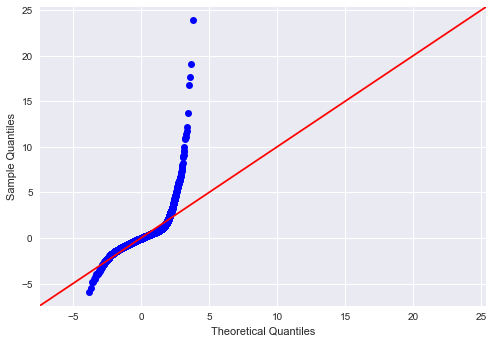

In [22]:
fig = sm.graphics.qqplot(base.resid, dist=stats.norm, line='45', fit=True)

* **Interpretation**: It is more spread out than supposed at these quantiles 

Now let's take a quick look of our homoscedastisity and check the residuals around the base line

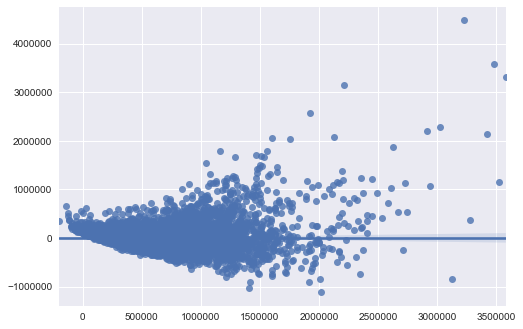

In [23]:
# plt.scatter(base.predict(x_train), base.resid)
sns.regplot(x=base.predict(x_train), y=base.resid);
# plt.plot(base.predict(x_train), [0 for i in range(len(x_train))]);

* We can see severe heteroscedasticity

* In my opinion the best way to tackle this problem is to first make the price more normal, we may lose some of our data, around 5%, because we are going to trim the price between two standard deviation (95% of data). 

### Model 2: Trim the price to 2 standard deviation on our DataFrame

In [24]:
df_trim_2st = df_fin_cat[(np.abs(stats.zscore(df_fin_cat.price)) < 2)]

In [25]:
#we lost 841 rows of data to have a better model
print(len(df_fin_cat)-len(df_trim_2st))

841


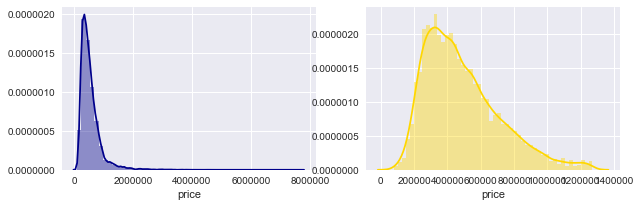

In [26]:
#we can see the shape of the price before and after the trim, which is quite normal 
#now we can check our model on prices between two standard deviation
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,3))
sns.distplot(df_fin_cat.price, color='darkblue', ax=axes[0])
sns.distplot(df_trim_2st.price, color='gold', ax=axes[1]);

In [27]:
x = df_trim_2st[x_cols]
y = df_trim_2st[['price']]


# Our Second TTS, test size is 20% of our data
x_train1, x_test1, y_train1, y_test1 = train_test_split(x,y,test_size=0.2,random_state=52)
print(len(x_train1), len(x_test1),len(y_train1),len(y_test1))
x_train.head()

16604 4152 16604 4152


,const,bedrooms,bathrooms,sqft_living,floors,waterfront,yr_built,sqft_living15,basement,renovated,...,city_Redmond,city_Renton,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,location_NW,location_SE,location_SW
15476,1.0,2,1,1210,1,0,1952,1210,0,0,...,0,0,0,1,0,0,0,0,0,0
13427,1.0,3,2,2120,2,0,1981,2620,0,0,...,0,0,0,0,0,0,0,0,0,0
20387,1.0,3,2,1270,2,0,2012,1490,0,0,...,0,0,0,1,0,0,0,0,0,0
4244,1.0,4,3,2680,2,0,2009,2750,0,0,...,1,0,0,0,0,0,0,0,0,0
12520,1.0,3,2,1380,1,0,1915,1250,1,0,...,0,0,0,1,0,0,0,1,0,0


In [28]:
x_train1 = sm.add_constant(x_train1)
x_test1 = sm.add_constant(x_test1)

/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [29]:
model_trainer(x_cols, target, x_train1, y_train1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1433.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:14:09   Log-Likelihood:            -2.1626e+05
No. Observations:               16604   AIC:                         4.326e+05
Df Residuals:                   16566   BIC:                         4.329e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.658e+06   9.66e+04     27.517      0.000    2.47e+06    2.85e+06
bedrooms           -1.157e+04   1262.274     -9.167      0.000    -1.4e+04   -9097.431
bathrooms           1.295e+04   1762.619      7.346      0.000    9492.549    1.64e+04
sqft_living           95.5522      2.301     41.533      0.000      91.043     100.062
floors              1.969e+04   2337.627      8.423      0.000    1.51e+04    2.43e+04
waterfront          2.911e+05   1.57e+04     18.531      0.000     2.6e+05    3.22e+05
yr_built           -1445.0546     49.630    -29.116      0.000   -1542.335   -1347.774
sqft_living15         52.6889      2.315     22.759      0.000      48.151      57.227
basement           -1512.4467   2101.486     -0.720      0.472   -5631.584    2606.691
renovated           3.405e+04   5231.072      6.509      0.000    2.38e+04    4.43e+04
condition           2.246e+04   1480.345     15.172      0.000    1.96e+04    2.54e+04
grade               6.527e+04   1401.290     46.579      0.000    6.25e+04     6.8e+04
city_Bellevue       1.449e+05   6638.433     21.827      0.000    1.32e+05    1.58e+05
city_Black Diamond  5.208e+04   1.38e+04      3.783      0.000    2.51e+04    7.91e+04
city_Bothell        -2.43e+04   1.05e+04     -2.306      0.021    -4.5e+04   -3647.202
city_Carnation     -5510.1414   1.27e+04     -0.433      0.665   -3.05e+04    1.94e+04
city_Duvall         -4.08e+04   1.06e+04     -3.843      0.000   -6.16e+04      -2e+04
city_Enumclaw      -1.252e+04   1.09e+04     -1.148      0.251   -3.39e+04    8862.093
city_Fall City      2.183e+04   1.55e+04      1.410      0.159   -8519.263    5.22e+04
city_Federal Way    -1.93e+04   5985.859     -3.225      0.001    -3.1e+04   -7570.209
city_Issaquah       5.747e+04   7068.369      8.130      0.000    4.36e+04    7.13e+04
city_Kenmore       -2.345e+04   9253.310     -2.534      0.011   -4.16e+04   -5310.612
city_Kent            -95.5956   5458.076     -0.018      0.986   -1.08e+04    1.06e+04
city_Kirkland       9.323e+04   6923.382     13.467      0.000    7.97e+04    1.07e+05
city_Maple Valley  -3519.1554   8799.228     -0.400      0.689   -2.08e+04    1.37e+04
city_Medina         5.194e+05   3.92e+04     13.238      0.000    4.43e+05    5.96e+05
city_Mercer Island  2.513e+05   1.05e+04     24.002      0.000    2.31e+05    2.72e+05
city_North Bend     7.467e+04   1.09e+04      6.857      0.000    5.33e+04     9.6e+04
city_Redmond        8.962e+04   6847.361     13.088      0.000    7.62e+04    1.03e+05
city_Renton         5.494e+04   5096.337     10.780      0.000     4.5e+04    6.49e+04
city_Sammamish       5.36e+04   7203.912      7.440      0.000    3.95e+04    6.77e+04
city_Seattle        7.691e+04   5057.765     15.205      0.000     6.7e+04    8.68e+04
city_Snoqualmie    -7145.3804   8854.0

*  Fortunately R-squared got better!

#### RMSE for Model 2: Price in 2 standard deviation

In [30]:
Sec_model = sm.OLS(y_train1,x_train1).fit()

In [31]:
calculate_rmse(x_train1, x_test1, y_train1, y_test1, Sec_model)

Train RMSE: 109682.37986295628
Test RMSE: 109857.3319205496


* Our RMSE decreased by a great amount(almost 80k)
* Our Train RMSE is no longer higher than our Test RMSE 

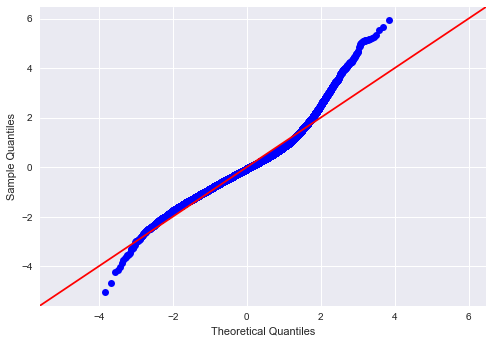

In [32]:
fig = sm.graphics.qqplot(Sec_model.resid, dist=stats.norm, line='45', fit=True)

* QQ Plot looks a lot better than before, but it is a little skewed mostly because of the skew in price

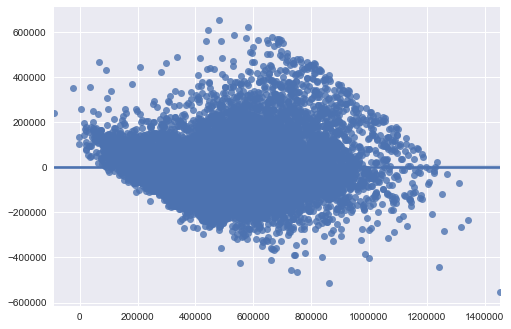

In [33]:
sns.regplot(x=Sec_model.predict(x_train1), y=Sec_model.resid);

* We addressed heteroscedasticity to some extend.
* now we can see data spread way better than previous model.

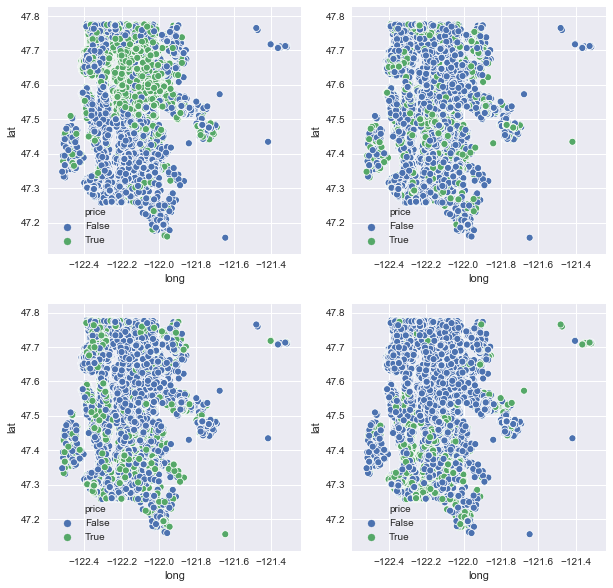

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
sns.scatterplot(df.long,df.lat,hue=df.price >= 613275,ax=axes[0,0])
sns.scatterplot(df.long,df.lat,hue=(df.price >= 440000) & (df.price < 613275),ax=axes[0,1])
sns.scatterplot(df.long,df.lat,hue=((df.price >= 317000) & (df.price < 440000)),ax=axes[1,0])
sns.scatterplot(df.long,df.lat,hue=(df.price < 317000),ax=axes[1,1]);

* As we can see normal-price houses are all over the king county
* Let's try to trim the price one more time to see if there is any difference or not

### Model 3: Price in one Standard Deviation

In [35]:
df_trim_1st = df_fin_cat[(np.abs(stats.zscore(df_fin_cat.price)) < 1)]

In [36]:
#we lost 1551 rows of data to have a better model
print(len(df_trim_2st)-len(df_trim_1st))

1551


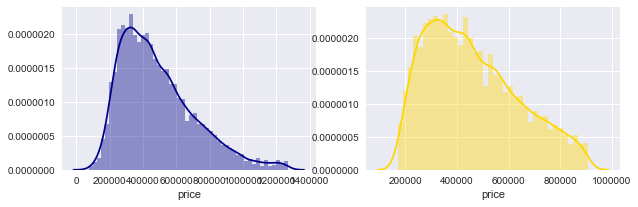

In [37]:
#To see the difference between our previous price and the new one
#we can see that it is more normal
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,3))
sns.distplot(df_trim_2st.price, color='darkblue', ax=axes[0])
sns.distplot(df_trim_1st.price, color='gold', ax=axes[1]);

In [38]:
#This is the price range that we can have for our business Problem
df_trim_1st.price.describe()

count     19205.000000
mean     460645.712367
std      177639.628404
min      173000.000000
25%      317000.000000
50%      431000.000000
75%      580000.000000
max      907500.000000
Name: price, dtype: float64

In [39]:
x = df_trim_1st[x_cols]
y = df_trim_1st[['price']]


# Our Second TTS, test size is 20% of our data
x_train2, x_test2, y_train2, y_test2 = train_test_split(x,y,test_size=0.2,random_state=52)
print(len(x_train2), len(x_test2),len(y_train2),len(y_test2))
x_train.head()

15364 3841 15364 3841


,const,bedrooms,bathrooms,sqft_living,floors,waterfront,yr_built,sqft_living15,basement,renovated,...,city_Redmond,city_Renton,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,location_NW,location_SE,location_SW
15476,1.0,2,1,1210,1,0,1952,1210,0,0,...,0,0,0,1,0,0,0,0,0,0
13427,1.0,3,2,2120,2,0,1981,2620,0,0,...,0,0,0,0,0,0,0,0,0,0
20387,1.0,3,2,1270,2,0,2012,1490,0,0,...,0,0,0,1,0,0,0,0,0,0
4244,1.0,4,3,2680,2,0,2009,2750,0,0,...,1,0,0,0,0,0,0,0,0,0
12520,1.0,3,2,1380,1,0,1915,1250,1,0,...,0,0,0,1,0,0,0,1,0,0


In [40]:
x_train2 = sm.add_constant(x_train2)
x_test2 = sm.add_constant(x_test2)

/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [41]:
model_trainer(x_cols, target, x_train2, y_train2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     1158.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:14:18   Log-Likelihood:            -1.9732e+05
No. Observations:               15364   AIC:                         3.947e+05
Df Residuals:                   15326   BIC:                         3.950e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                2.25e+06   8.52e+04     26.404      0.000    2.08e+06    2.42e+06
bedrooms           -8497.7916   1111.023     -7.649      0.000   -1.07e+04   -6320.054
bathrooms           1.253e+04   1538.929      8.140      0.000    9511.147    1.55e+04
sqft_living           79.4224      2.090     38.007      0.000      75.326      83.518
floors              1.575e+04   2052.654      7.675      0.000    1.17e+04    1.98e+04
waterfront          1.748e+05   1.73e+04     10.081      0.000    1.41e+05    2.09e+05
yr_built           -1201.9503     43.870    -27.398      0.000   -1287.941   -1115.960
sqft_living15         51.4647      2.089     24.639      0.000      47.370      55.559
basement           -2282.8938   1821.919     -1.253      0.210   -5854.071    1288.283
renovated           2.666e+04   4644.452      5.740      0.000    1.76e+04    3.58e+04
condition           1.951e+04   1292.599     15.092      0.000     1.7e+04     2.2e+04
grade               5.228e+04   1259.638     41.507      0.000    4.98e+04    5.48e+04
city_Bellevue        1.35e+05   5826.306     23.178      0.000    1.24e+05    1.46e+05
city_Black Diamond  5.348e+04   1.23e+04      4.344      0.000    2.93e+04    7.76e+04
city_Bothell        9651.1570   8876.115      1.087      0.277   -7747.082     2.7e+04
city_Carnation      1.746e+04   1.09e+04      1.606      0.108   -3844.938    3.88e+04
city_Duvall        -2.376e+04   8897.845     -2.671      0.008   -4.12e+04   -6322.827
city_Enumclaw      -1.768e+04   9218.311     -1.918      0.055   -3.58e+04     387.054
city_Fall City      3.332e+04    1.4e+04      2.387      0.017    5962.828    6.07e+04
city_Federal Way   -1.644e+04   5134.220     -3.202      0.001   -2.65e+04   -6376.129
city_Issaquah       8.481e+04   6057.911     13.999      0.000    7.29e+04    9.67e+04
city_Kenmore        -925.0823   7913.473     -0.117      0.907   -1.64e+04    1.46e+04
city_Kent          -1145.0271   4679.517     -0.245      0.807   -1.03e+04    8027.382
city_Kirkland       9.672e+04   5968.866     16.204      0.000     8.5e+04    1.08e+05
city_Maple Valley  -4835.5318   7562.254     -0.639      0.523   -1.97e+04    9987.383
city_Medina         4.621e+05    6.5e+04      7.114      0.000    3.35e+05    5.89e+05
city_Mercer Island  2.373e+05   1.11e+04     21.291      0.000    2.15e+05    2.59e+05
city_North Bend      7.06e+04   9309.828      7.583      0.000    5.24e+04    8.88e+04
city_Redmond        1.141e+05   5916.358     19.277      0.000    1.02e+05    1.26e+05
city_Renton         5.832e+04   4376.659     13.326      0.000    4.97e+04    6.69e+04
city_Sammamish      8.618e+04   6260.176     13.766      0.000    7.39e+04    9.84e+04
city_Seattle        7.351e+04   4383.371     16.770      0.000    6.49e+04    8.21e+04
city_Snoqualmie     2.008e+04   7754.3

* R-Squared decreased but not much!

#### RMSE for Model 3: Price in One Standard Deviation

In [42]:
Third_model = sm.OLS(y_train2,x_train2).fit()

In [43]:
calculate_rmse(x_train2, x_test2, y_train2, y_test2, Third_model)

Train RMSE: 91483.19977635038
Test RMSE: 92902.65226611811


* Our RMSE decreased by a great amount(almost 10k)
* Our Train RMSE is no longer higher than our Test RMSE 

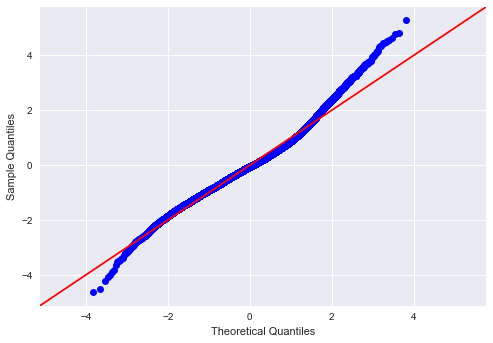

In [44]:
fig = sm.graphics.qqplot(Third_model.resid, dist=stats.norm, line='45', fit=True)

* QQ Plot looks a lot better than before, but it is a little skewed mostly because of the skew in price

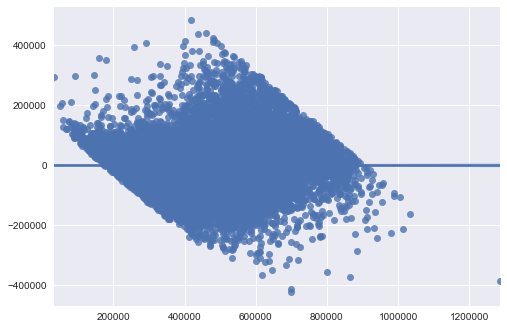

In [45]:
sns.regplot(x=Third_model.predict(x_train2), y=Third_model.resid);
# plt.scatter(Third_model.predict(x_train2), Third_model.resid)

# plt.plot(Third_model.predict(x_train2), [0 for i in range(len(x_train2))]);

* We addressed heteroscedasticity to some extend.
* This heteroscedasticity is due to high p-values in features

### Model 4: StepWise Selection with p-values

In [46]:
%run -i "StepWise.py"

<Figure size 576x396 with 0 Axes>

In [47]:
result = stepwise_selection(x_train2, y_train2, verbose=True)

/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  grade                          with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  const                          with p-value 0.0
Add  location_SW                    with p-value 0.0
Add  location_SE                    with p-value 0.0
Add  sqft_living15                  with p-value 3.17717e-100
Add  city_Federal Way               with p-value 2.98438e-48
Add  condition                      with p-value 4.44777e-46
Add  city_Mercer Island             with p-value 1.36541e-42
Add  waterfront                     with p-value 1.56051e-42
Add  city_Kent                      with p-value 3.56107e-40
Add  city_Kenmore                   with p-value 8.43572e-40
Add  city_Duvall                    with p-value 4.45722e-41
Add  city_Bellevue                  with p-value 3.16499e-34
Add  floors                         with p-value 3.59902e-30
Add  city_Redmond                   with p-value 2.38307e-24
Add  city_

StepWise.py:43: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  worst_feature = pvalues.argmax()


Add  bathrooms                      with p-value 5.08493e-12
Add  bedrooms                       with p-value 5.32029e-16
Add  city_Medina                    with p-value 1.28264e-11
Add  renovated                      with p-value 8.11536e-09
Add  location_NW                    with p-value 2.39019e-08
Add  city_Woodinville               with p-value 8.11039e-09
Drop city_Kenmore                   with p-value 0.195306
Add  city_Black Diamond             with p-value 1.70399e-07
Add  city_Snoqualmie                with p-value 0.00542973


In [48]:
# 3 columns droped and the remaining is as follows
result

['grade',
 'yr_built',
 'sqft_living',
 'const',
 'location_SW',
 'location_SE',
 'sqft_living15',
 'city_Federal Way',
 'condition',
 'city_Mercer Island',
 'waterfront',
 'city_Duvall',
 'city_Bellevue',
 'floors',
 'city_Redmond',
 'city_Seattle',
 'city_Vashon',
 'city_Kirkland',
 'city_Renton',
 'city_Issaquah',
 'city_Sammamish',
 'city_North Bend',
 'bathrooms',
 'bedrooms',
 'city_Medina',
 'renovated',
 'location_NW',
 'city_Woodinville',
 'city_Black Diamond',
 'city_Snoqualmie']

In [49]:
x_train3 = x_train2.loc[:,result]
x_test3 = x_test2.loc[:,result]

In [50]:
model_trainer(result, target, x_train3, y_train2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     1476.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:14:33   Log-Likelihood:            -1.9733e+05
No. Observations:               15364   AIC:                         3.947e+05
Df Residuals:                   15334   BIC:                         3.949e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
grade               5.219e+04   1254.929     41.590      0.000    4.97e+04    5.47e+04
yr_built           -1203.1607     43.618    -27.584      0.000   -1288.657   -1117.665
sqft_living           79.2115      2.031     38.997      0.000      75.230      83.193
const               2.256e+06   8.48e+04     26.601      0.000    2.09e+06    2.42e+06
location_SW        -1.315e+05   2761.101    -47.617      0.000   -1.37e+05   -1.26e+05
location_SE        -8.551e+04   3835.827    -22.292      0.000    -9.3e+04    -7.8e+04
sqft_living15         51.6755      2.081     24.837      0.000      47.597      55.754
city_Federal Way   -1.728e+04   4343.963     -3.978      0.000   -2.58e+04   -8764.311
condition           1.927e+04   1286.906     14.976      0.000    1.68e+04    2.18e+04
city_Mercer Island   2.34e+05   1.05e+04     22.379      0.000    2.13e+05    2.54e+05
waterfront           1.75e+05   1.73e+04     10.095      0.000    1.41e+05    2.09e+05
city_Duvall         -2.69e+04   7992.177     -3.366      0.001   -4.26e+04   -1.12e+04
city_Bellevue       1.318e+05   4363.105     30.202      0.000    1.23e+05     1.4e+05
floors              1.653e+04   1898.963      8.703      0.000    1.28e+04    2.02e+04
city_Redmond        1.111e+05   4449.953     24.956      0.000    1.02e+05     1.2e+05
city_Seattle        7.108e+04   2953.428     24.068      0.000    6.53e+04    7.69e+04
city_Vashon         1.561e+05   1.06e+04     14.709      0.000    1.35e+05    1.77e+05
city_Kirkland       9.346e+04   4540.940     20.582      0.000    8.46e+04    1.02e+05
city_Renton          5.77e+04   3320.502     17.378      0.000    5.12e+04    6.42e+04
city_Issaquah       8.289e+04   4649.924     17.825      0.000    7.38e+04     9.2e+04
city_Sammamish      8.327e+04   4902.629     16.984      0.000    7.37e+04    9.29e+04
city_North Bend     7.574e+04   7579.336      9.993      0.000    6.09e+04    9.06e+04
bathrooms           1.215e+04   1522.492      7.978      0.000    9161.821    1.51e+04
bedrooms           -8585.4548   1109.502     -7.738      0.000   -1.08e+04   -6410.699
city_Medina         4.584e+05   6.49e+04      7.067      0.000    3.31e+05    5.86e+05
renovated           2.672e+04   4644.392      5.753      0.000    1.76e+04    3.58e+04
location_NW         1.936e+04   2767.532      6.996      0.000    1.39e+04    2.48e+04
city_Woodinville    3.867e+04   5841.184      6.620      0.000    2.72e+04    5.01e+04
city_Black Diamond  5.882e+04   1.11e+04      5.318      0.000    3.71e+04    8.05e+04
city_Snoqualmie     1.855e+04   6671.927      2.781      0.005    5475.284    3.16e+04
==============================================================================
Omnibus:                      990.411   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (J

* R-squared didn't change but our p-values are all significant

#### RMSE for Model 4: StepWise Selection with p-values

In [51]:
StepWise_model = sm.OLS(y_train2, x_train3).fit()

In [52]:
calculate_rmse(x_train3, x_test3, y_train2, y_test2, StepWise_model)

Train RMSE: 91531.03991387258
Test RMSE: 92911.29904674359


* RMSE also did not Change! (in comparison with previous model)

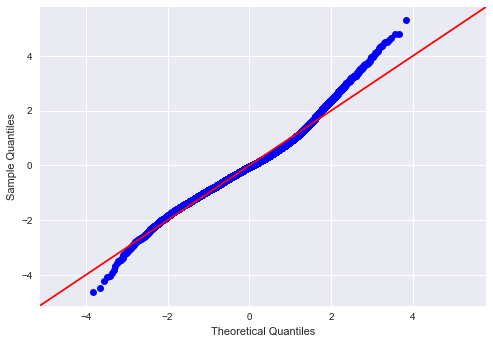

In [53]:
fig = sm.graphics.qqplot(StepWise_model.resid, dist=stats.norm, line='45', fit=True)

* There is no difference with previous Model!

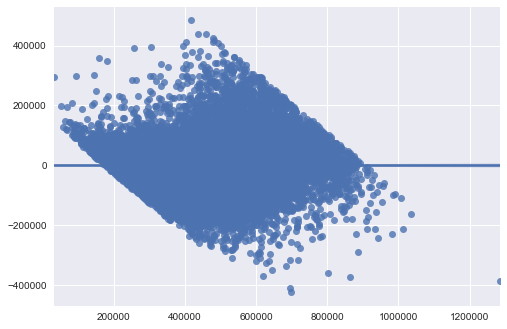

In [54]:
sns.regplot(x=StepWise_model.predict(x_train3), y=StepWise_model.resid);

* We addressed heteroscedasticity
* Our Residuals are almost the same in all parts of the dataset.

### Model 5: Interactions

* Create a baseline model which includes all the variables we selected from the housing data set to predict the house prices. Then use 15-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [55]:
x = x_train2
y = y_train2

regression = LinearRegression()

crossvalidation = KFold(n_splits=15, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, x, y, scoring='r2', cv=crossvalidation))

baseline

0.7346439170275826

* Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the $R^2$. We'll look at the 15 interactions which have the biggest effect on our $R^2$.

In [56]:
interactions = []

feat_combinations = combinations(x.columns, 2)

data = x.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
            
# print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[1], reverse=True)[:3])

In [57]:
#number of interactions that their mean R^2 is higher than our baseline
len(interactions)

547

In [58]:
interactions[0]

('const', 'bedrooms', 0.735)

In [59]:
interactions[0][:2]

('const', 'bedrooms')

In [60]:
top10_interactions = sorted(interactions, key=lambda inter: inter[2], reverse=True)[:10]
top10_interactions

[('grade', 'city_Seattle', 0.741),
 ('grade', 'location_NW', 0.74),
 ('grade', 'location_SW', 0.739),
 ('sqft_living', 'location_NW', 0.738),
 ('sqft_living', 'location_SW', 0.738),
 ('sqft_living15', 'location_SW', 0.738),
 ('sqft_living', 'city_Federal Way', 0.737),
 ('sqft_living', 'city_Seattle', 0.737),
 ('sqft_living15', 'city_Federal Way', 0.737),
 ('sqft_living15', 'city_Seattle', 0.737)]

In [61]:
top10_ints = [i[:2] for i in top10_interactions]
top10_ints = [list(elem) for elem in top10_ints]
top10_ints  

[['grade', 'city_Seattle'],
 ['grade', 'location_NW'],
 ['grade', 'location_SW'],
 ['sqft_living', 'location_NW'],
 ['sqft_living', 'location_SW'],
 ['sqft_living15', 'location_SW'],
 ['sqft_living', 'city_Federal Way'],
 ['sqft_living', 'city_Seattle'],
 ['sqft_living15', 'city_Federal Way'],
 ['sqft_living15', 'city_Seattle']]

In [62]:
top10_ints[0][0]

'grade'

In [63]:
# def plot_add_model_ints(interactions, target, x_train, y_train):
#     x_use = pd.concat([x_train,y_train], axis = 1)
#     for inter in interactions:
#         fig, ax = plt.subplots()
#         is_in = x_use.loc[x_use[inter[1]]] == 1, [inter[0], target]
#         linreg = LinearRegression()
#         linreg.fit(is_in[[inter[0]]], is_in[target])
#         a = is_in[inter[0]].values.reshape(-1,1)
#         preds1 = linreg.predict(a)
#         ax.scatter(is_in[inter[0]], is_in[target], alpha=.3, label=None)
#         ax.plot(a, preds1, label='Inside the {} : {}'.format(inter[1], round(linreg.coef_[0],2)))
        
#         not_in = x_use.loc[x_use[inter[1]]] == 0, [inter[0], target]
#         linreg = LinearRegression()
#         linreg.fit(not_in[[inter[0]]], not_in[target])
#         b = not_in[inter[0]].values.reshape(-1,1)
#         preds2 = linreg.predict(b)
#         ax.scatter(not_in[inter[0]], not_in[target], alpha=.1, label=None)
#         ax.plot(b, preds2, label='Outside the {} : {}'.format(inter[1], round(linreg.coef_[0],2)))

#         ax.legend();
        

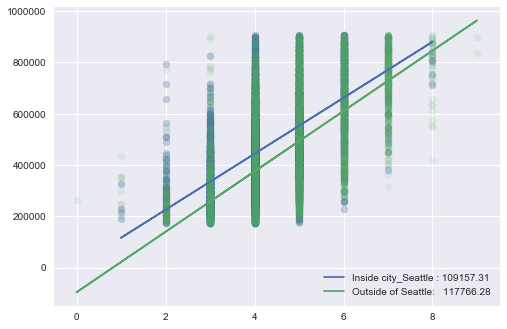

In [64]:
fig, ax = plt.subplots()
col = 'grade'
is_in = df_trim_1st.loc[df_trim_1st['city_Seattle'] == 1, [col, 'price']]
linreg = LinearRegression()
linreg.fit(is_in[[col]], is_in['price'])


city1 = is_in[col].values.reshape(-1,1)
preds = linreg.predict(city1)


ax.scatter(is_in[[col]], is_in['price'], alpha=.3, label=None)
ax.plot(city1, preds, label='Inside {} : {}'.format(top10_ints[0][1], round(linreg.coef_[0],2)))


not_in = df_trim_1st.loc[df_trim_1st['city_Seattle'] == 0, [col, 'price']]

linreg = LinearRegression()
linreg.fit(not_in[[col]], not_in['price'])

city2 = not_in[col].values.reshape(-1,1)
preds = linreg.predict(city2)



ax.scatter(not_in[[col]], not_in['price'], alpha=.1, label=None)
ax.plot(city2, preds, label=f'Outside of Seattle:   {linreg.coef_[0]:.2f}')

ax.legend();

In [65]:
linreg.coef_[0]

117766.27605527565

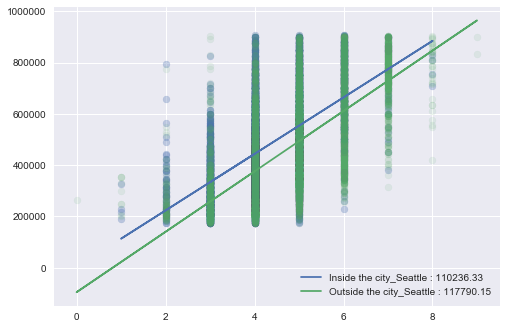

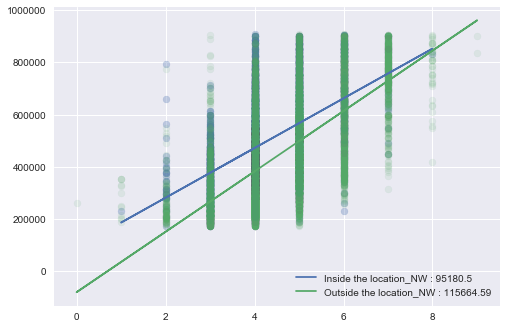

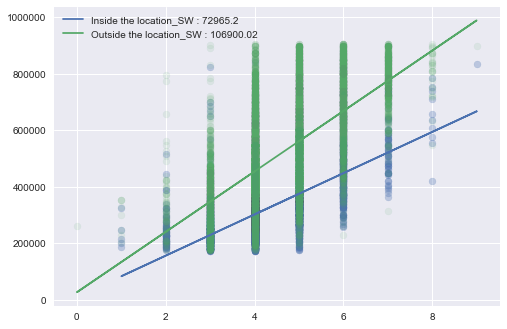

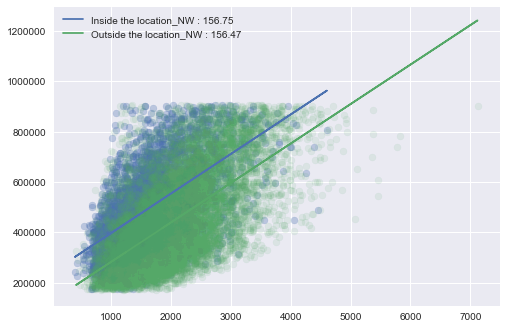

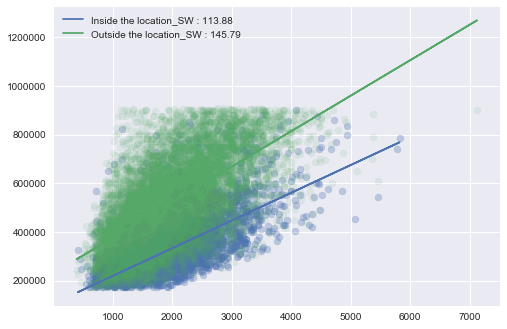

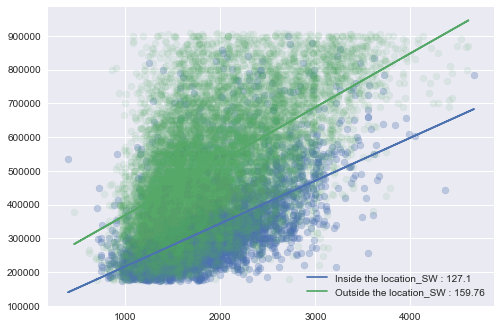

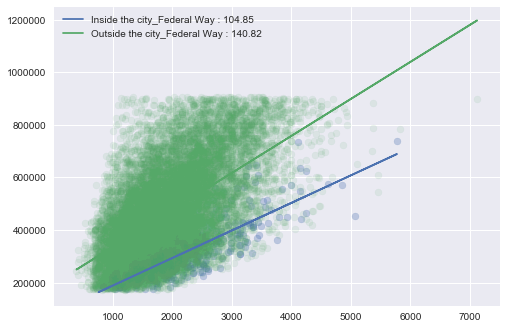

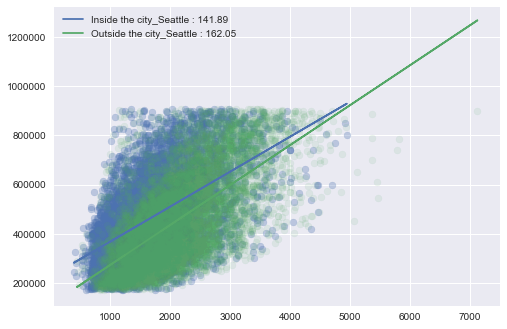

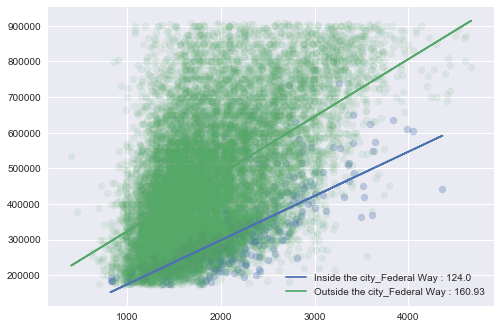

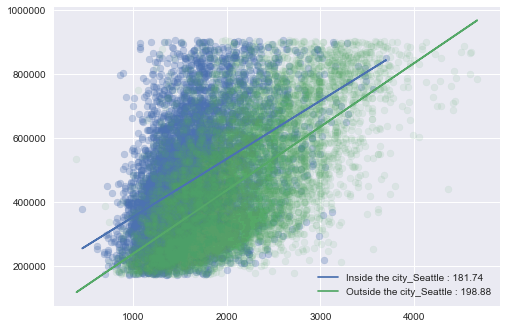

In [66]:
x_use = pd.concat([x_train2,y_train2], axis = 1)
for inter in top10_ints:
    col = inter[0]
    fig, ax = plt.subplots()
    is_in = x_use.loc[x_use[inter[1]] == 1, [col, target]]
    linreg = LinearRegression()
    linreg.fit(is_in[[col]], is_in[target])
    a = is_in[inter[0]].values.reshape(-1,1)
    preds1 = linreg.predict(a)
    ax.scatter(is_in[inter[0]], is_in[target], alpha=.3, label=None)
    ax.plot(a, preds1, label='Inside the {} : {}'.format(inter[1], round(linreg.coef_[0],2)))
    
    not_in = x_use.loc[x_use[inter[1]] == 0, [inter[0], target]]
    linreg = LinearRegression()
    linreg.fit(not_in[[inter[0]]], not_in[target])
    b = not_in[inter[0]].values.reshape(-1,1)
    preds2 = linreg.predict(b)
    ax.scatter(not_in[inter[0]], not_in[target], alpha=.1, label=None)
    ax.plot(b, preds2, label='Outside the {} : {}'.format(inter[1], round(linreg.coef_[0],2)))
    ax.legend();

In [67]:
x_train4 = x.copy()
x_test4 = x_test2.copy()

In [68]:
for inter in top10_ints:
    x_train4[inter[0]+'*'+inter[1]] = x_train4[inter[0]] * x_train4[inter[1]]

for inter in top10_ints:
    x_test4[inter[0]+'*'+inter[1]] = x_test4[inter[0]] * x_test4[inter[1]]

In [69]:
x_test4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3841 entries, 6742 to 3909
Data columns (total 48 columns):
const                             3841 non-null float64
bedrooms                          3841 non-null int64
bathrooms                         3841 non-null int64
sqft_living                       3841 non-null int64
floors                            3841 non-null int64
waterfront                        3841 non-null int64
yr_built                          3841 non-null int64
sqft_living15                     3841 non-null int64
basement                          3841 non-null int64
renovated                         3841 non-null int64
condition                         3841 non-null int64
grade                             3841 non-null int64
city_Bellevue                     3841 non-null uint8
city_Black Diamond                3841 non-null uint8
city_Bothell                      3841 non-null uint8
city_Carnation                    3841 non-null uint8
city_Duvall             

In [70]:
final_baseline = np.mean(cross_val_score(regression, x_train4, y, scoring='r2', cv=crossvalidation))

final_baseline

0.7455547128844289

* in comparison to our first baseline (0.7346439170275826) we have slightly better result

In [71]:
x_cols = list(x_train4.columns)

In [72]:
model_trainer(x_cols, target, x_train4, y_train2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     966.4
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:17:00   Log-Likelihood:            -1.9698e+05
No. Observations:               15364   AIC:                         3.941e+05
Df Residuals:                   15316   BIC:                         3.944e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           2.411e+06   8.51e+04     28.346      0.000    2.24e+06    2.58e+06
bedrooms                       -1.084e+04   1097.722     -9.875      0.000    -1.3e+04   -8688.519
bathrooms                       1.213e+04   1517.281      7.994      0.000    9155.335    1.51e+04
sqft_living                       86.5881      2.782     31.120      0.000      81.134      92.042
floors                          1.405e+04   2045.003      6.872      0.000       1e+04    1.81e+04
waterfront                      1.707e+05    1.7e+04     10.036      0.000    1.37e+05    2.04e+05
yr_built                       -1269.3985     43.558    -29.143      0.000   -1354.777   -1184.020
sqft_living15                     57.6599      2.998     19.232      0.000      51.783      63.536
basement                       -7790.6854   1808.713     -4.307      0.000   -1.13e+04   -4245.393
renovated                       1.882e+04   4563.245      4.124      0.000    9873.756    2.78e+04
condition                       1.667e+04   1272.421     13.104      0.000    1.42e+04    1.92e+04
grade                           4.533e+04   1777.292     25.505      0.000    4.18e+04    4.88e+04
city_Bellevue                   1.332e+05   5811.005     22.925      0.000    1.22e+05    1.45e+05
city_Black Diamond              5.165e+04    1.2e+04      4.286      0.000     2.8e+04    7.53e+04
city_Bothell                    5609.7378   8758.352      0.641      0.522   -1.16e+04    2.28e+04
city_Carnation                  1.078e+04   1.07e+04      1.011      0.312   -1.01e+04    3.17e+04
city_Duvall                    -2.933e+04   8757.566     -3.349      0.001   -4.65e+04   -1.22e+04
city_Enumclaw                  -1.856e+04   9025.248     -2.057      0.040   -3.63e+04    -870.475
city_Fall City                  2.684e+04   1.37e+04      1.963      0.050      36.655    5.37e+04
city_Federal Way                6.087e+04    1.5e+04      4.052      0.000    3.14e+04    9.03e+04
city_Issaquah                   8.456e+04   6045.831     13.986      0.000    7.27e+04    9.64e+04
city_Kenmore                   -4824.4061   7799.725     -0.619      0.536   -2.01e+04    1.05e+04
city_Kent                        568.2471   4581.613      0.124      0.901   -8412.259    9548.754
city_Kirkland                   9.423e+04   5897.486     15.979      0.000    8.27e+04    1.06e+05
city_Maple Valley              -5937.5261   7414.863     -0.801      0.423   -2.05e+04    8596.487
city_Medina                     4.589e+05   6.36e+04      7.218      0.000    3.34e+05    5.84e+05
city_Mercer Island              2.343e+05    1.1e+04     21.275      0.000    2.13e+05    2.56e+05
city_North Bend                 7.064e+04   9123.883      7.743      0.000    5.28e+04    8.85e+04
city_Redmond  

* our $R^2$ increased!

#### RMSE for Model 5: Interactions

In [73]:
Interactions_model = sm.OLS(y_train2, x_train4).fit()

In [74]:
calculate_rmse(x_train4, x_test4, y_train2, y_test2, Interactions_model)

Train RMSE: 89490.31459842446
Test RMSE: 91591.81075787515


* our RMSE improved as well as our $R^2$

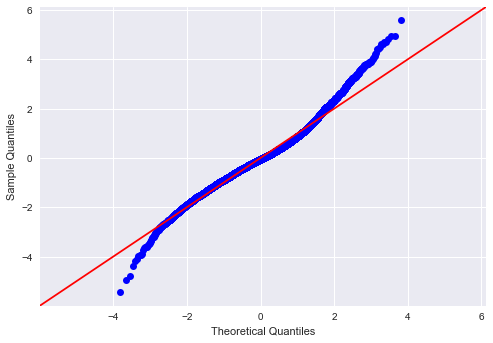

In [75]:
fig = sm.graphics.qqplot(Interactions_model.resid, dist=stats.norm, line='45', fit=True)

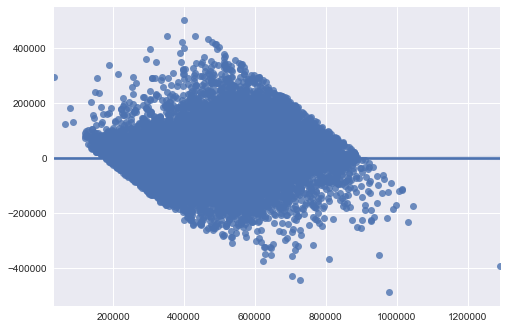

In [76]:
sns.regplot(x=Interactions_model.predict(x_train4), y=Interactions_model.resid);

### Final Model : StepWise on Interactions

In [80]:
result = stepwise_selection(x_train4, y_train2, verbose=True)

/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  grade                          with p-value 0.0
Add  grade*location_SW              with p-value 0.0
Add  location_SE                    with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  const                          with p-value 0.0
Add  sqft_living15                  with p-value 1.38872e-100
Add  condition                      with p-value 1.78465e-45
Add  grade*city_Seattle             with p-value 3.78296e-45
Add  city_Bellevue                  with p-value 1.65603e-57
Add  city_Mercer Island             with p-value 1.97751e-55
Add  city_Vashon                    with p-value 1.23465e-53
Add  city_Redmond                   with p-value 1.09517e-48
Add  city_Renton                    with p-value 5.32767e-52
Add  city_Kirkland                  with p-value 1.18199e-48
Add  city_Issaquah                  with p-value 1.01394e-41
Add  city_Sammamish                 with p-value 2.38954e-45
Add  floor

In [81]:
x_train5 = x_train4.loc[:,result]
x_test5 = x_test4.loc[:,result]



In [86]:
model_trainer(result, target, x_train5, y_train2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1373.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:31:02   Log-Likelihood:            -1.9700e+05
No. Observations:               15364   AIC:                         3.941e+05
Df Residuals:                   15330   BIC:                         3.943e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
grade                          4.54e+04   1582.447     28.691      0.000    4.23e+04    4.85e+04
grade*location_SW             -1.67e+04   2364.657     -7.061      0.000   -2.13e+04   -1.21e+04
location_SE                  -8.945e+04   3701.174    -24.167      0.000   -9.67e+04   -8.22e+04
sqft_living                     81.5403      2.069     39.406      0.000      77.484      85.596
yr_built                     -1265.8563     43.272    -29.254      0.000   -1350.674   -1181.038
const                         2.406e+06   8.45e+04     28.455      0.000    2.24e+06    2.57e+06
sqft_living15                   64.9053      2.347     27.657      0.000      60.305      69.505
condition                     1.654e+04   1267.353     13.051      0.000    1.41e+04     1.9e+04
grade*city_Seattle            2.914e+04   1865.566     15.618      0.000    2.55e+04    3.28e+04
city_Bellevue                 1.289e+05   4191.718     30.749      0.000    1.21e+05    1.37e+05
city_Mercer Island            2.282e+05   1.02e+04     22.345      0.000    2.08e+05    2.48e+05
city_Vashon                   1.497e+05   1.04e+04     14.403      0.000    1.29e+05     1.7e+05
city_Redmond                  1.066e+05   4281.394     24.898      0.000    9.82e+04    1.15e+05
city_Renton                   5.667e+04   3233.423     17.526      0.000    5.03e+04     6.3e+04
city_Kirkland                 9.061e+04   4330.866     20.921      0.000    8.21e+04    9.91e+04
city_Issaquah                 8.209e+04   4509.495     18.205      0.000    7.33e+04    9.09e+04
city_Sammamish                7.826e+04   4818.713     16.240      0.000    6.88e+04    8.77e+04
floors                        1.352e+04   2010.865      6.724      0.000    9579.508    1.75e+04
waterfront                     1.74e+05    1.7e+04     10.245      0.000    1.41e+05    2.07e+05
sqft_living*location_NW         14.0766      1.428      9.854      0.000      11.277      16.877
city_North Bend               7.646e+04   7417.881     10.308      0.000    6.19e+04     9.1e+04
bedrooms                     -1.111e+04   1090.984    -10.179      0.000   -1.32e+04   -8966.545
bathrooms                     1.197e+04   1508.804      7.931      0.000    9008.937    1.49e+04
city_Medina                   4.522e+05   6.35e+04      7.122      0.000    3.28e+05    5.77e+05
city_Woodinville              3.333e+04   5670.747      5.878      0.000    2.22e+04    4.44e+04
city_Seattle                 -5.616e+04   8197.750     -6.851      0.000   -7.22e+04   -4.01e+04
city_Black Diamond            5.723e+04   1.08e+04      5.287      0.000     3.6e+04    7.84e+04
sqft_living15*location_SW      -17.1770      4.141     -4.148      0.000     -25.294      -9.060
basement                     -7903.1142   1801.754     -4.386      0.000   -

In [87]:
Final_model = sm.OLS(y_train2, x_train5).fit()

In [92]:
#Top 15 Coefficients in our model
summary = Final_model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
i = p_table[((p_table[''] == 'const'))].index
p_table.drop(i,inplace=True)
p_table = p_table.sort_values(by = 'coef', ascending=False)

p_table.tail(15)

,,coef,std err,t,P>|t|,[0.025,0.975]
32,renovated,1.858e+04,4563.080,4.072,0.000,9637.859,2.75e+04
8,condition,1.654e+04,1267.353,13.051,0.000,1.41e+04,1.9e+04
12,city_Vashon,1.497e+05,1.04e+04,14.403,0.000,1.29e+05,1.7e+05
18,floors,1.352e+04,2010.865,6.724,0.000,9579.508,1.75e+04
10,city_Bellevue,1.289e+05,4191.718,30.749,0.000,1.21e+05,1.37e+05
23,bathrooms,1.197e+04,1508.804,7.931,0.000,9008.937,1.49e+04
13,city_Redmond,1.066e+05,4281.394,24.898,0.000,9.82e+04,1.15e+05
2,grade*location_SW,-1.67e+04,2364.657,-7.061,0.000,-2.13e+04,-1.21e+04
1,grade,4.54e+04,1582.447,28.691,0.000,4.23e+04,4.85e+04
19,waterfront,1.74e+05,1.7e+04,10.245,0.000,1.41e+05,2.07e+05


Coefficient Interpretaion : when city_Federal Way is True our price is increased by 44160$

#### RMSE for Final Model

In [89]:
calculate_rmse(x_train5, x_test5, y_train2, y_test2, Final_model)

Train RMSE: 89602.67341438225
Test RMSE: 91714.24057488481


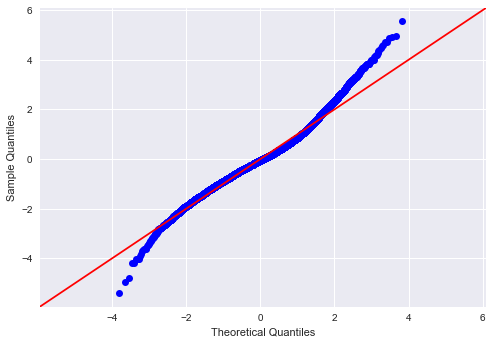

In [90]:
fig = sm.graphics.qqplot(Final_model.resid, dist=stats.norm, line='45', fit=True)

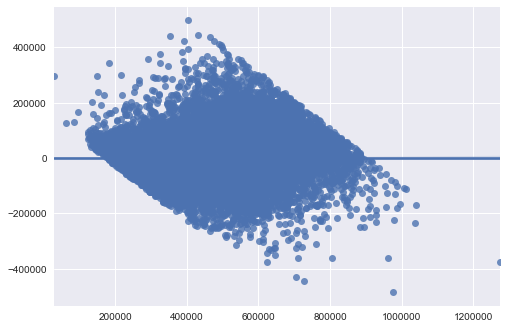

In [91]:
sns.regplot(x=Final_model.predict(x_train5), y=Final_model.resid);

### Model 6: Polynomial Regression

degree 2 -8578.594918562201


ValueError: x and y must have same first dimension, but have shapes (15364, 38) and (3841, 1)

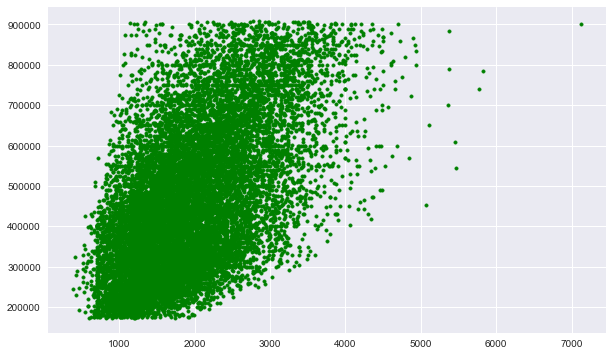

In [280]:
colors = ['yellow', 'lightgreen', 'blue','red']
plt.figure(figsize=(10, 6))
plt.scatter(x_train4['sqft_living'], y_train2, color='green', s=50, marker='.', label='plot points')

# We'll fit 3 different polynomial regression models from degree 2 to degree 4
for index, degree in enumerate([2, 3, 4]):
    
    # Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree)
    
    # Fit and transform X_train
    X_poly_train = poly.fit_transform(x_train2)
    
    # Instantiate and fit a linear regression model to the polynomial transformed train features
    reg_poly = LinearRegression().fit(X_poly_train, y_train2)
    
    # Transform the test data into polynomial features
    X_poly_test = poly.transform(x_test2)
    
    # Get predicted values for transformed polynomial test data  
    y_pred = reg_poly.predict(X_poly_test)
    
    # Evaluate model performance on test data
    print("degree %d" % degree, r2_score(y_test2, y_pred))
    
    # Transform the full data
    X_poly = poly.transform(df_trim_1st)
    
    # Now, we want to see what the model predicts for the entire data  
    y_poly = reg_poly.predict(X_poly)
    
    # Create plot of predicted values
    plt.plot(x_train2, y_pred, color = colors[index], linewidth=2, label='degree %d' % degree)
    plt.legend(loc='lower left')